### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention iss all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [6]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

`Tavily` is the real‑time search engine for AI agents and RAG workflows

In [8]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\achra\AppData\Local\Temp\ipykernel_18232\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [10]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'AI Pulse News Roundup (March 2025 Edition) - Community',
  'url': 'https://community.openai.com/t/ai-pulse-news-roundup-march-2025-edition/1132414',
  'content': 'Anthropic presented updated AI policy recommendations to the White House, advocating enhanced national security testing, stricter export controls, and expanded infrastructure. The proposal underscores Anthropic’s push for stronger governance of powerful AI systems. (Anthropic)\n\nDuckDuckGo expanded its privacy-focused AI offerings, providing anonymized access to major chatbots and AI-enhanced search results. This feature aligns with the company’s commitment to safeguarding user data in the AI-driven web. (Spread Privacy)\n\nGoogle co-founder Larry Page launched Dynatomics, an AI company leveraging LLMs to generate factory-ready product designs. The startup aims to streamline industrial manufacturing by automating creative and engineering processes. (TechCrunch) [...] McDonald’s is upgrading its 43,000 restaurants

In [11]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [14]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-20b")

llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "What is the recent AI News". Likely they want a summary of recent AI news. We need to browse recent news. We can use tavily_search_results_json to find recent AI news. Let\'s search.', 'tool_calls': [{'id': 'fc_8bfdb0ba-77cf-43f2-aab3-12bbe4050e8e', 'function': {'arguments': '{"query":"recent AI news 2026"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 291, 'total_tokens': 370, 'completion_time': 0.080623612, 'completion_tokens_details': {'reasoning_tokens': 47}, 'prompt_time': 0.014183549, 'prompt_tokens_details': None, 'queue_time': 0.016748653, 'total_time': 0.094807161}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_9340e7d14d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019ca4d4-b058-73f1-9544-2ec5e844fa9f-0', tool_calls=[{'n

In [16]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'fc_d9b11b55-25f5-492c-a3b9-af0393fd03e7',
  'type': 'tool_call'}]

In [17]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

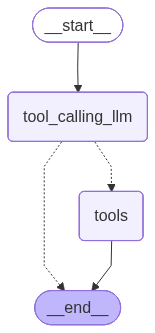

In [18]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_778ae1d9-cb20-4220-878d-edec0ab8f951)
 Call ID: fc_778ae1d9-cb20-4220-878d-edec0ab8f951
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [20]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_78e29f64-ef2e-459a-9c2e-f025141259c0)
 Call ID: fc_78e29f64-ef2e-459a-9c2e-f025141259c0
  Args:
    query: AI news March 3 2025 top 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI INTELLIGENCE | Weekly Top 10 (3/7/25) - Dwealth.news", "url": "https://dwealth.news/2025/03/ai-intelligence-weekly-top-10-3-7-25/", "content": "Home AI & Finance AI Intelligence AI INTELLIGENCE | Weekly Top 10 (3/7/25)\n\n AI & Finance\n AI Intelligence\n\n# AI INTELLIGENCE | Weekly Top 10 (3/7/25)\n\nBy\n\nDWN Staff\n\n-\n\n4524\n\nFacebookTwitterWhatsAppLinkedinReddItEmailPrint\n\n​The week of March 1 to March 7, 2025, was marked by significant developments in arti

In [21]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

**Machine learning** is a branch of artificial intelligence (AI) that focuses on building systems that can learn from data, identify patterns, and make decisions or predictions with minimal human intervention.

Key points:

| Aspect | Description |
|--------|-------------|
| **Learning from data** | Models are trained on large datasets to capture relationships or patterns. |
| **Algorithms** | Common types include supervised learning (classification, regression), unsupervised learning (clustering, dimensionality reduction), semi‑supervised learning, and reinforcement learning. |
| **Model evaluation** | Performance is assessed using metrics like accuracy, precision, recall, F1‑score, or mean squared error, and often validated via cross‑validation or hold‑out test sets. |
| **Applications** | From ima